In [23]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import keras.backend as K

In [24]:
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

# 1. Problem Discription

## 1.1 About Data
Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.

The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

- tracking faces in images and video
- analysing facial expressions
- detecting dysmorphic facial signs for medical diagnosis
- biometrics / face recognition

## 1.2 Metric
The metric for evaluation is given as Mean Absolute Error(MAE), which is defined as,
\begin{equation*}
MAE = \frac{1}{n} \sum_{i=1}^{n} (\hat y_i - y_i)^2 
\end{equation*}
where,
${\hat y_i}$ is the predicted value and ${y_i}$ is the true value.

# 2. EDA

In [25]:
raw_train = pd.read_csv('training/training.csv')
raw_train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


Here, we can see that the 1st 30 columns of the training.csv file has the target labels and the last column has the image data.

In [26]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

Here, we can see that,
- out of the total 30 target variables, only 8 features are present in more than 7000 observations.
- Remaining 22 features are available for little over 2000 datapoints.
- We can divide the train data in such a way that 7000 datapoints with 8 features present form one dataset and 2000 datapoints with all features present form another. This idea was presented by Ahmed Saied (https://www.kaggle.com/phylake1337/2-15-loss-simple-split-trick) in his notebook.

In [27]:
test = pd.read_csv('test/test.csv')
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [28]:
test.shape

(1783, 2)

Here, we are given a string of integer representing the vaulue of pixel in grayscale images along with the ImageId.

In [29]:
id_lookup = pd.read_csv('IdLookupTable.csv')
id_lookup.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [30]:
id_lookup.shape

(27124, 4)

Here, we have the id_lookup which gives us the information on final submission format that we have to make. Notice that the number of rows we have to predict is much less than the number of rows multiplied by the number of features i.e. 1783x30 = 53490. Therefore, we have to predict select features for the test data.

# Data Preprocessing

In [31]:
# Seperating the 8-feature dataset from 30-feature dataset.
def seperate_data(data):
    col_names = ['left_eye_center_x','left_eye_center_y','right_eye_center_x','right_eye_center_y','nose_tip_x','nose_tip_y',
                'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y','Image']
    data_30 = data.dropna().reset_index()
    data_30.drop('index',inplace=True,axis=1)
    data_8 = data[col_names].dropna().reset_index()
    data_8.drop('index',inplace=True,axis=1)
    return data_30,data_8

In [32]:
train_30_raw,train_8_raw = seperate_data(raw_train)
print(train_30_raw.shape)
print(train_8_raw.shape)

(2140, 31)
(7000, 9)


In [33]:
train_30_raw.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [34]:
def str_to_img(data):
    final = np.zeros((len(data),96,96,1),dtype=np.float32)
    for i in tqdm(range(len(data))):
        temp = np.array([int(i)/255 for i in data[i].split()],dtype = np.float32)
        temp = temp.reshape(96,96,1)
        final[i] = temp
    return final

In [35]:
X_8 = str_to_img(train_8_raw['Image'].values)
print(X_8.shape)
np.savez_compressed('train_8',X_8)

100%|█████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:17<00:00, 391.67it/s]


(7000, 96, 96, 1)


In [36]:
X_30 = str_to_img(train_30_raw['Image'].values)
print(X_30.shape)
np.savez_compressed('train_30',X_30)

100%|█████████████████████████████████████████████████████████████████████████████| 2140/2140 [00:06<00:00, 350.62it/s]


(2140, 96, 96, 1)


In [37]:
Y_8 = train_8_raw.drop('Image',axis=1)
Y_30 = train_30_raw.drop('Image',axis=1)

In [49]:
y_8 = Y_8.to_numpy()
y_30 = Y_30.to_numpy()

# Plotting the images

In [59]:
def plot_img_30(index):
    plt.imshow(X_30[index][:,:,0])
    for i in range(0,30,2):
        plt.plot(y_30[index][i],y_30[index][i+1],'r.')

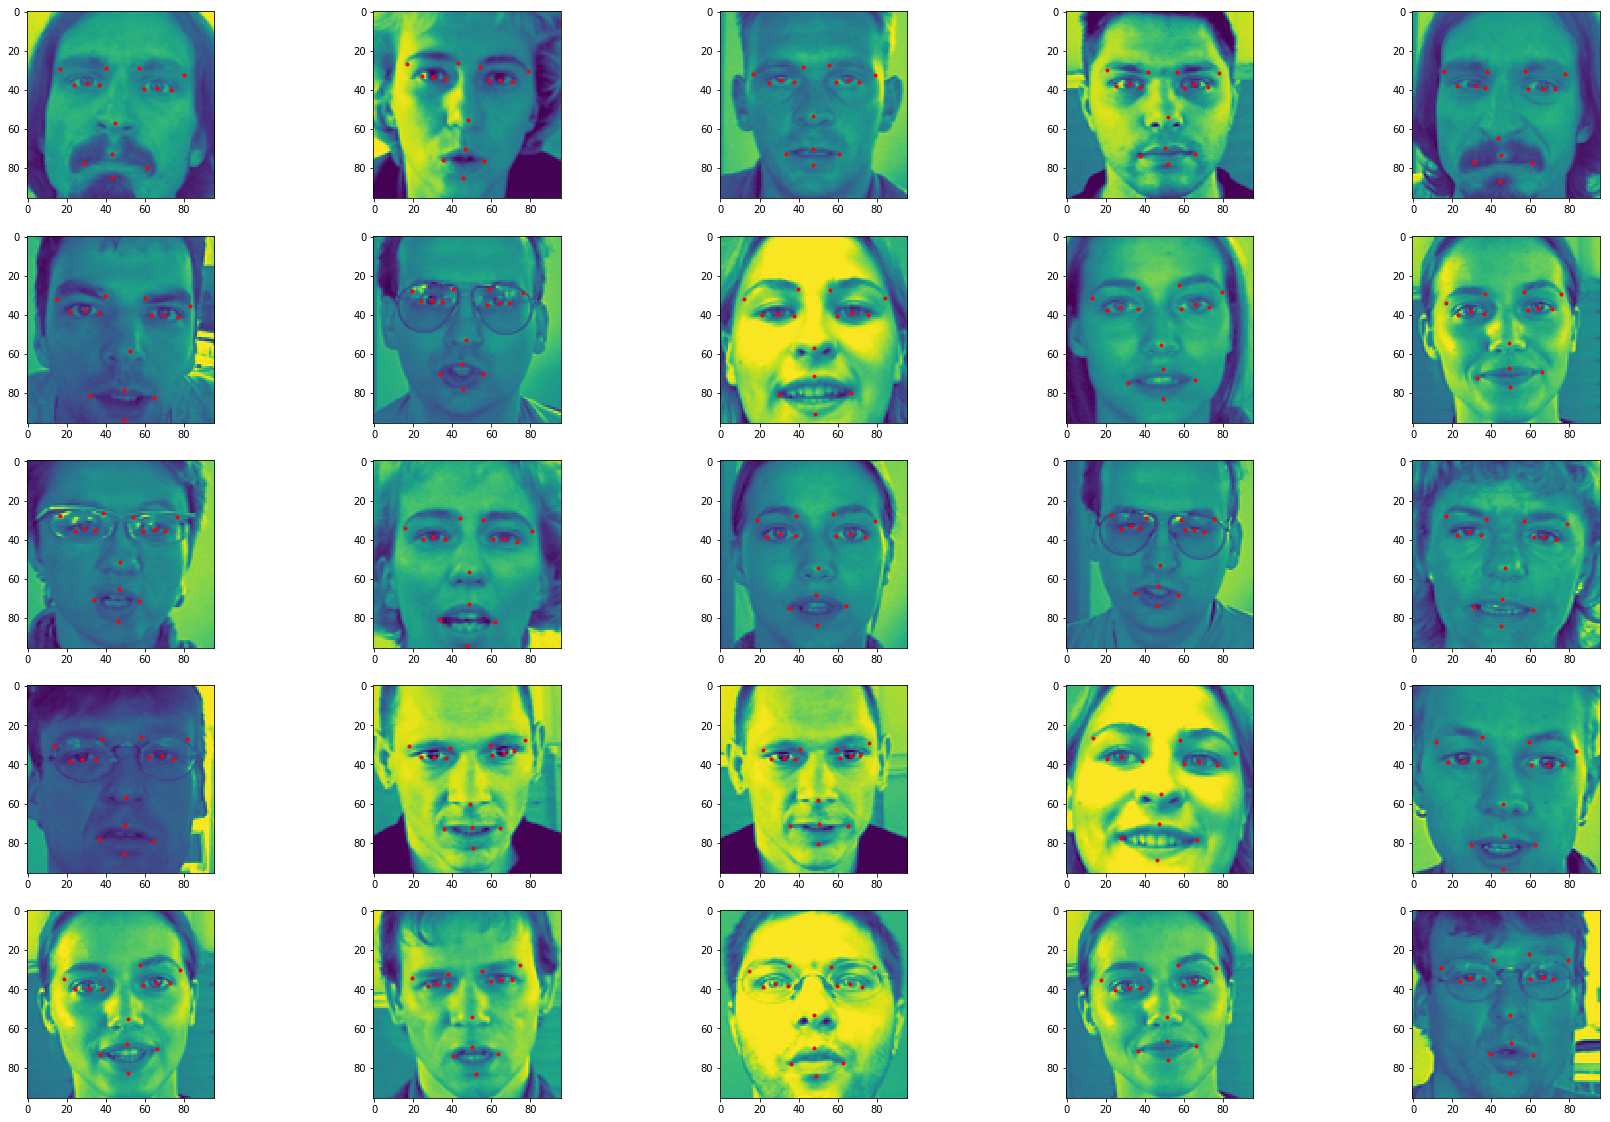

In [60]:
fig = plt.figure(figsize=(30,20))
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    plot_img_30(i)
plt.show()

In [63]:
def plot_img_8(index):
    plt.imshow(X_8[index][:,:,0])
    for i in range(0,8,2):
        plt.plot(y_8[index][i],y_8[index][i+1],'r.')

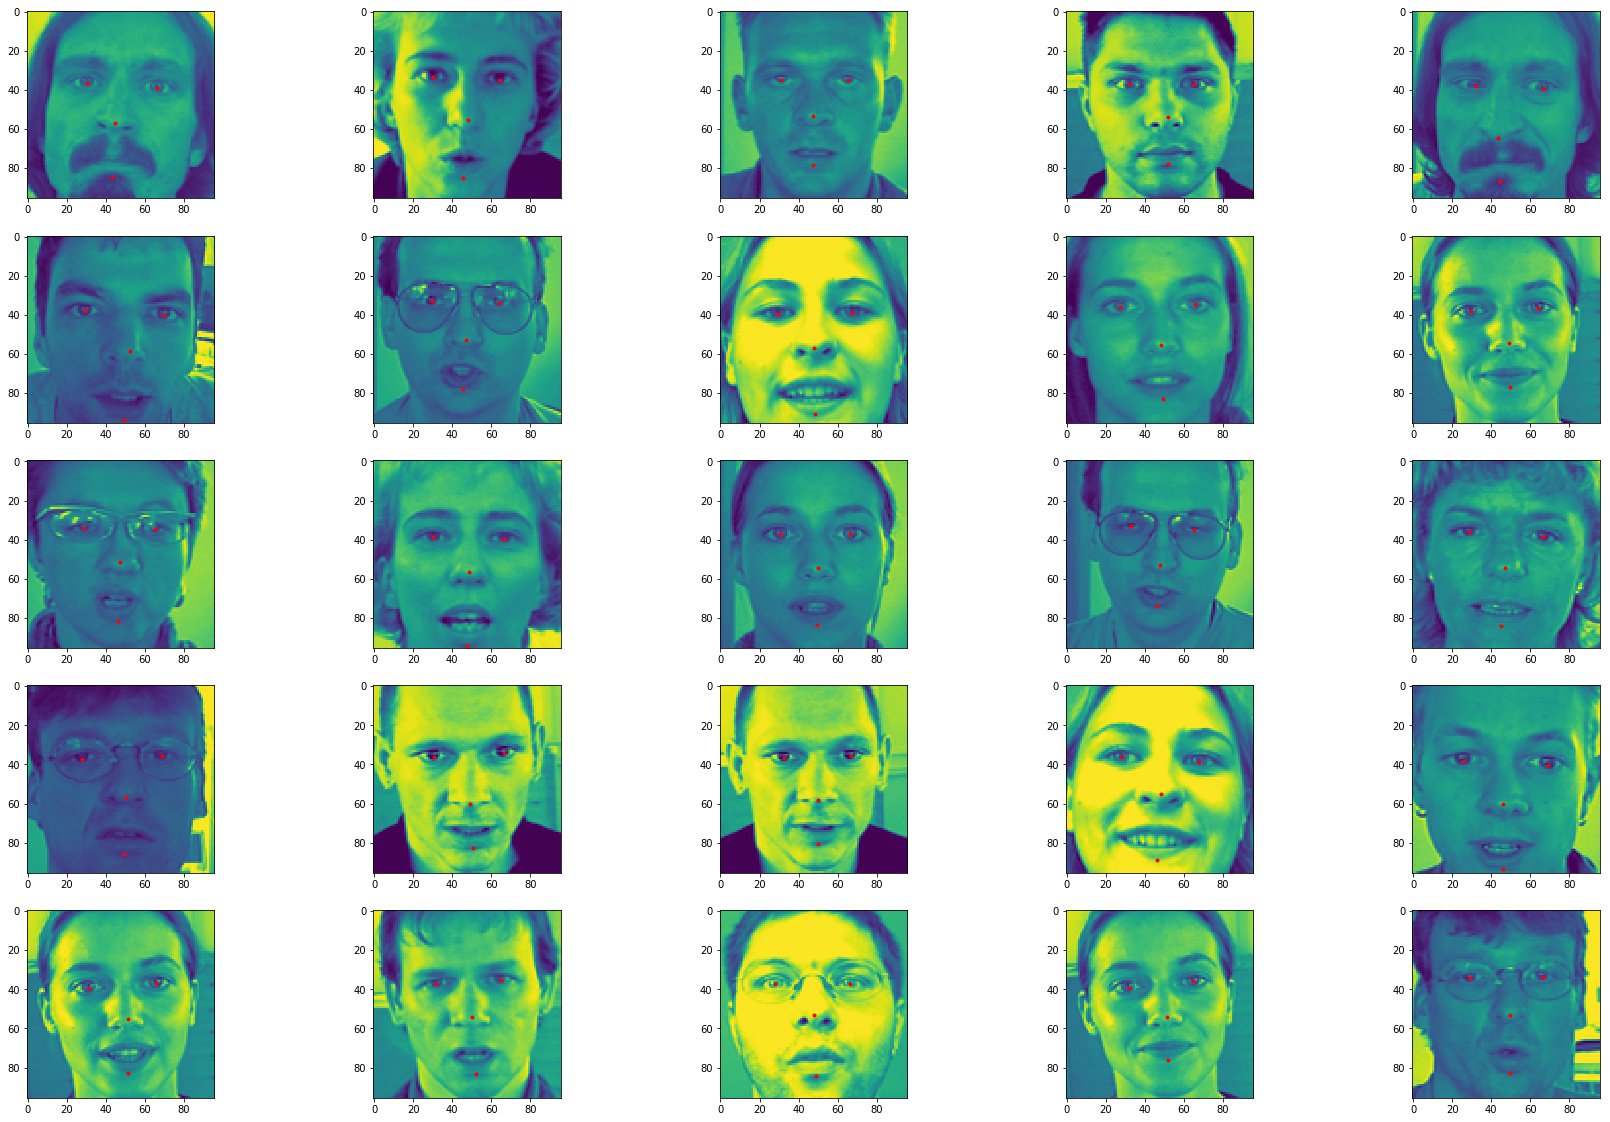

In [64]:
fig = plt.figure(figsize=(30,20))
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    plot_img_8(i)
plt.show()

# Define a Model
We will be using a yolonet-like model for detection of keypoints. It seems fitting because yolonet is specifically designed for localization.

In [50]:
from keras.layers import Conv2D,MaxPooling2D,Input,ZeroPadding2D,BatchNormalization,LeakyReLU,UpSampling2D,Dense,Flatten,Dropout,Concatenate,MaxPool2D
from keras.layers.merge import add,concatenate
from keras.models import Model,Sequential

### For 8 feature dataset

In [ ]:
def custom_model(output=30):
    input_image = Input(shape=(96,96,1),name='input')
    x = Conv2D(32,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_1',padding='same')(input_image)
    x = BatchNormalization(name='BN_1')(x)
    x = LeakyReLU(0.1,name='leakyrelu_1')(x)
    
    
    x = Conv2D(32,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_2')(x)
    x = BatchNormalization(name='BN_2')(x)
    x = LeakyReLU(0.1,name='leakyrelu_2')(x)
    
    x = MaxPooling2D(pool_size=(2,2),name='maxpooling_1')(x)
    
    x = Conv2D(64,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_3',padding='same')(x)
    x = BatchNormalization(name='BN_3')(x)
    x = LeakyReLU(0.1,name='leakyrelu_3')(x)
    
    
    x = Conv2D(64,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_4')(x)
    x = BatchNormalization(name='BN_4')(x)
    x = LeakyReLU(0.1,name='leakyrelu_4')(x)
    
    x = MaxPooling2D(pool_size=(2,2),name='maxpooling_2')(x)
    
    x = x = Conv2D(64,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_5',padding='same')(x)
    x = BatchNormalization(name='BN_5')(x)
    x = LeakyReLU(0.1,name='leakyrelu_5')(x)
    
    
    x = Conv2D(64,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_6')(x)
    x = BatchNormalization(name='BN_6')(x)
    x = LeakyReLU(0.1,name='leakyrelu_6')(x)
    
    x = MaxPooling2D(pool_size=(2,2),name='maxpooling_3')(x)
    
    x = Conv2D(128,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_7',padding='same')(x)
    x = BatchNormalization(name='BN_7')(x)
    x = LeakyReLU(0.1,name='leakyrelu_7')(x)
    
    
    x = Conv2D(128,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_8')(x)
    x = BatchNormalization(name='BN_8')(x)
    x = LeakyReLU(0.1,name='leakyrelu_8')(x)
    
    x = x = Conv2D(256,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_9',padding='same')(x)
    x = BatchNormalization(name='BN_9')(x)
    x = LeakyReLU(0.1,name='leakyrelu_9')(x)
    
    
    x = Conv2D(256,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_10')(x)
    x = BatchNormalization(name='BN_10')(x)
    x = LeakyReLU(0.1,name='leakyrelu_10')(x)
    
    
    x = x = Conv2D(512,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_11',padding='same')(x)
    x = BatchNormalization(name='BN_11')(x)
    x = LeakyReLU(0.1,name='leakyrelu_11')(x)
    
    
    x = Conv2D(512,kernel_size=(3,3),kernel_initializer='glorot_normal',name='conv2d_12')(x)
    x = BatchNormalization(name='BN_12')(x)
    x = LeakyReLU(0.1,name='leakyrelu_12')(x)
    
    x = MaxPooling2D(pool_size=(2,2),name='maxpooling_4')(x)
    
    x = Flatten(name='flatten_1')(x)
    
    x = Dense(256,kernel_initializer='glorot_normal',name='dense_1')(x)
    x = Dropout(0.2,name='dropout_1')(x)
    final = Dense(output,kernel_initializer='glorot_normal',name='dense_2')(x)
    
    model = Model(input_image,final)
    return model

In [70]:
model_8 = custom_model(output=8)

In [71]:
model_8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 96, 96, 32)        128       
_________________________________________________________________
leakyrelu_1 (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 94, 94, 32)        128       
_________________________________________________________________
leakyrelu_2 (LeakyReLU)      (None, 94, 94, 32)        0         
__________

In [72]:
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,TensorBoard
tensorboard = TensorBoard(log_dir="Model_8_new")
reduce = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=.5, min_lr=0.00001)
mc = ModelCheckpoint('best_model_8_new.h5py', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [73]:
model_8.compile(loss=keras.losses.mse,optimizer=keras.optimizers.Adam(lr=0.001),metrics=['mae'])
result = model_8.fit(X_8, Y_8,batch_size=32,epochs=100,verbose=2,validation_split=0.1,callbacks=[reduce,mc,tensorboard])

Train on 6300 samples, validate on 700 samples
Epoch 1/100
 - 17s - loss: 64.6054 - mean_absolute_error: 5.2961 - val_loss: 15.9912 - val_mean_absolute_error: 2.7278

Epoch 00001: val_loss improved from inf to 15.99117, saving model to best_model_8_new.h5py
Epoch 2/100
 - 15s - loss: 23.1444 - mean_absolute_error: 3.6969 - val_loss: 18.1970 - val_mean_absolute_error: 3.2285

Epoch 00002: val_loss did not improve from 15.99117
Epoch 3/100
 - 15s - loss: 18.1123 - mean_absolute_error: 3.2333 - val_loss: 25.0756 - val_mean_absolute_error: 3.7403

Epoch 00003: val_loss did not improve from 15.99117
Epoch 4/100
 - 15s - loss: 15.3638 - mean_absolute_error: 2.9767 - val_loss: 10.6601 - val_mean_absolute_error: 2.0982

Epoch 00004: val_loss improved from 15.99117 to 10.66006, saving model to best_model_8_new.h5py
Epoch 5/100
 - 15s - loss: 13.4144 - mean_absolute_error: 2.7769 - val_loss: 10.7853 - val_mean_absolute_error: 2.0177

Epoch 00005: val_loss did not improve from 10.66006
Epoch 6/10


Epoch 00044: val_loss did not improve from 6.71266
Epoch 45/100
 - 15s - loss: 4.6914 - mean_absolute_error: 1.6546 - val_loss: 6.8070 - val_mean_absolute_error: 1.3651

Epoch 00045: val_loss did not improve from 6.71266
Epoch 46/100
 - 15s - loss: 4.8002 - mean_absolute_error: 1.6743 - val_loss: 6.6820 - val_mean_absolute_error: 1.3569

Epoch 00046: val_loss improved from 6.71266 to 6.68200, saving model to best_model_8_new.h5py
Epoch 47/100
 - 15s - loss: 4.7279 - mean_absolute_error: 1.6582 - val_loss: 7.6966 - val_mean_absolute_error: 1.5245

Epoch 00047: val_loss did not improve from 6.68200
Epoch 48/100
 - 15s - loss: 4.8237 - mean_absolute_error: 1.6797 - val_loss: 7.4008 - val_mean_absolute_error: 1.4500

Epoch 00048: val_loss did not improve from 6.68200
Epoch 49/100
 - 15s - loss: 4.8320 - mean_absolute_error: 1.6824 - val_loss: 7.7534 - val_mean_absolute_error: 1.5227

Epoch 00049: val_loss did not improve from 6.68200
Epoch 50/100
 - 15s - loss: 4.8331 - mean_absolute_erro

## Mean squared loss

## Mean absolute error

## Mean squared loss validation

## Mean absolute error validation


### For 30 feature dataset

In [66]:
model_30 = custom_model(output=30)

In [67]:
model_30.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 96, 96, 32)        128       
_________________________________________________________________
leakyrelu_1 (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 94, 94, 32)        128       
_________________________________________________________________
leakyrelu_2 (LeakyReLU)      (None, 94, 94, 32)        0         
__________

In [68]:
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,TensorBoard
tensorboard = TensorBoard(log_dir="Model_30")
reduce = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=.5, min_lr=0.00001)
mc = ModelCheckpoint('best_model_30.h5py', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [69]:
model_30.compile(loss=keras.losses.mse,optimizer=keras.optimizers.Adam(lr=0.001),metrics=['mae'])
result = model_30.fit(X_30, Y_30,batch_size=32,epochs=100,verbose=2,validation_split=0.1,callbacks=[reduce,mc,tensorboard])

Train on 1926 samples, validate on 214 samples
Epoch 1/100
 - 7s - loss: 163.0389 - mean_absolute_error: 8.1722 - val_loss: 98.5521 - val_mean_absolute_error: 7.6882

Epoch 00001: val_loss improved from inf to 98.55208, saving model to best_model_30.h5py
Epoch 2/100
 - 5s - loss: 36.9393 - mean_absolute_error: 4.8040 - val_loss: 20.5434 - val_mean_absolute_error: 3.4896

Epoch 00002: val_loss improved from 98.55208 to 20.54345, saving model to best_model_30.h5py
Epoch 3/100
 - 5s - loss: 27.8239 - mean_absolute_error: 4.1590 - val_loss: 38.1768 - val_mean_absolute_error: 5.1343

Epoch 00003: val_loss did not improve from 20.54345
Epoch 4/100
 - 5s - loss: 24.2402 - mean_absolute_error: 3.8707 - val_loss: 12.7847 - val_mean_absolute_error: 2.6825

Epoch 00004: val_loss improved from 20.54345 to 12.78468, saving model to best_model_30.h5py
Epoch 5/100
 - 5s - loss: 20.2910 - mean_absolute_error: 3.5369 - val_loss: 19.9996 - val_mean_absolute_error: 3.5390

Epoch 00005: val_loss did not i

Epoch 00088: val_loss did not improve from 3.89848
Epoch 89/100
 - 5s - loss: 5.0232 - mean_absolute_error: 1.7156 - val_loss: 3.9935 - val_mean_absolute_error: 1.3288

Epoch 00089: val_loss did not improve from 3.89848
Epoch 90/100
 - 5s - loss: 4.8793 - mean_absolute_error: 1.6995 - val_loss: 4.0111 - val_mean_absolute_error: 1.3301

Epoch 00090: val_loss did not improve from 3.89848
Epoch 91/100
 - 5s - loss: 5.2128 - mean_absolute_error: 1.7449 - val_loss: 4.0820 - val_mean_absolute_error: 1.3702

Epoch 00091: val_loss did not improve from 3.89848
Epoch 92/100
 - 5s - loss: 5.0971 - mean_absolute_error: 1.7307 - val_loss: 4.0077 - val_mean_absolute_error: 1.3265

Epoch 00092: val_loss did not improve from 3.89848
Epoch 93/100
 - 5s - loss: 5.0554 - mean_absolute_error: 1.7228 - val_loss: 3.9613 - val_mean_absolute_error: 1.3239

Epoch 00093: val_loss did not improve from 3.89848
Epoch 94/100
 - 5s - loss: 5.1582 - mean_absolute_error: 1.7419 - val_loss: 4.0172 - val_mean_absolute_e

## Mean squared loss

## Mean absolute error

## Mean squared loss validation

## Mean absolute error validation


# Predicting for test dataset

In [2]:
test = pd.read_csv('test/test.csv')

In [4]:
test_df = str_to_img(test['Image'].values)

100%|█████████████████████████████████████████████████████████████████████████████| 1783/1783 [00:04<00:00, 399.65it/s]


In [5]:
print(test_df.shape)

(1783, 96, 96, 1)


In [6]:
from keras.models import load_model
model_8 = load_model('best_model_8_new.h5py')
model_30 = load_model('best_model_30.h5py')








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [7]:
test_30 = model_30.predict(test_df)
test_8 = model_8.predict(test_df)

In [8]:
feature_8_ind = [0, 1, 2, 3, 20, 21, 28, 29] #indices for features is 8-feature dataset
for i in range(8):
    test_30[:,feature_8_ind[i]] = test_8[:,i]

# Making submission

In [10]:
# submission does not require all the predictions. The required features and datapoints are available in the lookup table.
id_lookup = pd.read_csv('IdLookupTable.csv')
id_lookup.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [14]:
features = id_lookup['FeatureName'].values
imageId = id_lookup['ImageId'].values
feature_id = dict(zip(raw_train.columns,range(30)))

In [15]:
req_preds = []
for x,y in zip(imageId,features):
    req_preds.append(test_30[x-1,feature_id[y]])

In [17]:
len(req_preds)

27124

In [22]:
submission = pd.DataFrame()
submission['RowId'] = [*range(1,27125)]
submission['Location'] = req_preds
submission.to_csv('submission.csv',index=False)